[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/YichenShen0103/CUMCM-25C/blob/main/problem3.ipynb)

In [1]:
!pip install scikit-survival
!pip install lifelines
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.preprocessing import StandardScaler
from sksurv.tree import SurvivalTree
from sksurv.util import Surv
from sksurv.nonparametric import kaplan_meier_estimator
from sksurv.metrics import concordance_index_censored
from lifelines.statistics import multivariate_logrank_test
from sksurv.util import Surv

warnings.filterwarnings("ignore")

In [2]:
url = 'https://raw.githubusercontent.com/YichenShen0103/CUMCM-25C/main/data/data.xlsx'
data = pd.read_excel(url, sheet_name=0)

# 移除体重和身高之后的变量
features = [
    "年龄", "体重", "IVF妊娠", "孕妇BMI", "怀孕次数", "生产次数"
]
feature_names_english = [
    "Age", "Weight", "IVF_Pregnancy", "BMI", "Pregnancy_Count", "Delivery_Count"
]

target = "Y染色体浓度"

data = data[features + [target]]
data.dropna(inplace=True)

# Extract features and target variable
X = data[features]
y = data[target]

# Data preprocessing
# Convert IVF_Pregnancy to binary (Natural=0, IVF=1)
X["IVF妊娠"] = X["IVF妊娠"].map({"自然受孕": 0, "IVF（试管婴儿）": 1,  "IUI（人工授精）": 1})

# Handle Pregnancy_Count (replace "≥3" with 3 and convert to int)
X["怀孕次数"] = X["怀孕次数"].replace("≥3", 3).astype(int)

# Handle missing values (fill with mean for numeric columns)
X = X.fillna(X.mean(numeric_only=True))

# Remove rows where target variable is missing
valid_idx = y.notna()
X = X[valid_idx]
y = y[valid_idx]
print(f"Data shape after cleaning: {X.shape}")

Data shape after cleaning: (1082, 6)



Top 5 key factors affecting Y chromosome concentration:
          features  importance
3              BMI    0.360276
1           Weight    0.333458
0              Age    0.200668
4  Pregnancy_Count    0.058555
5   Delivery_Count    0.044537


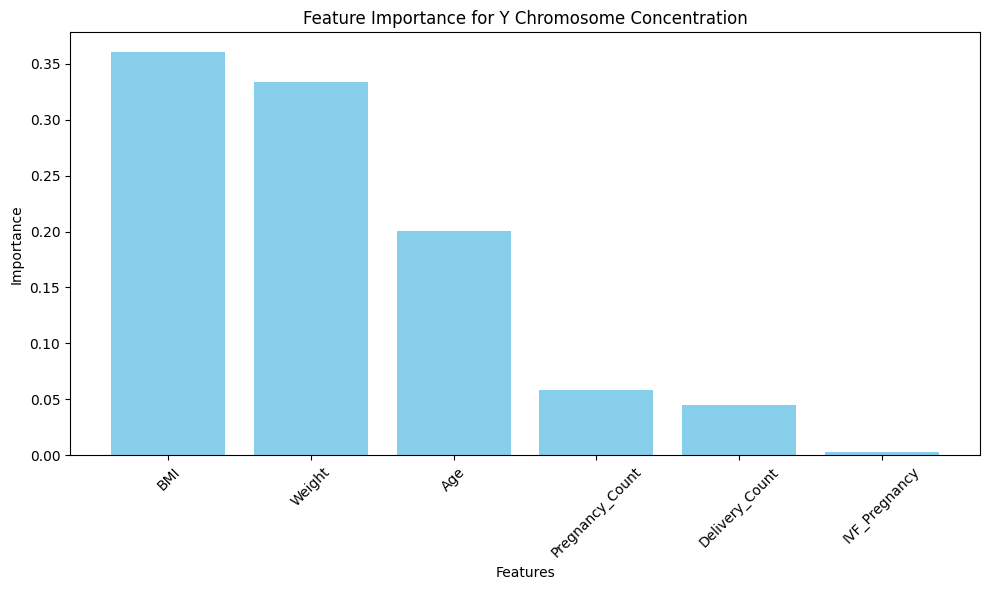

In [3]:
# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=feature_names_english)

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Train Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Get feature importance
feature_importance = pd.DataFrame({
    "features": feature_names_english,
    "importance": rf_model.feature_importances_
})
feature_importance = feature_importance.sort_values(by="importance", ascending=False)

# Print top 5 key factors
print("\nTop 5 key factors affecting Y chromosome concentration:")
print(feature_importance.head(5))

# Visualize feature importance
plt.figure(figsize=(10, 6))
plt.bar(feature_importance["features"], feature_importance["importance"], color="skyblue")
plt.xlabel("Features")
plt.ylabel("Importance")
plt.title("Feature Importance for Y Chromosome Concentration")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
plt.close()


Correlation Matrix:
                      Age    Weight  IVF_Pregnancy       BMI  Pregnancy_Count  \
Age              1.000000  0.045974       0.130193  0.001417         0.225011   
Weight           0.045974  1.000000      -0.055958  0.835304         0.050805   
IVF_Pregnancy    0.130193 -0.055958       1.000000 -0.082608        -0.000353   
BMI              0.001417  0.835304      -0.082608  1.000000         0.055695   
Pregnancy_Count  0.225011  0.050805      -0.000353  0.055695         1.000000   
Delivery_Count   0.149179  0.021223      -0.075354  0.057726         0.618114   

                 Delivery_Count  
Age                    0.149179  
Weight                 0.021223  
IVF_Pregnancy         -0.075354  
BMI                    0.057726  
Pregnancy_Count        0.618114  
Delivery_Count         1.000000  


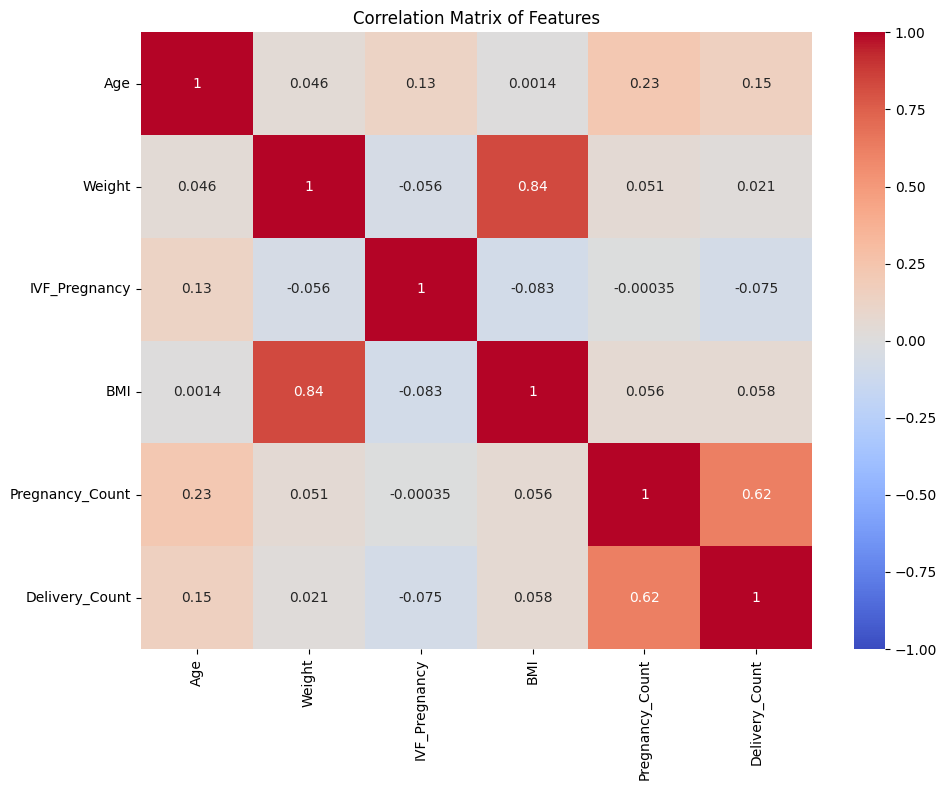


Variance Inflation Factor (VIF):
           Feature       VIF
3              BMI  3.355568
1           Weight  3.347340
4  Pregnancy_Count  1.672420
5   Delivery_Count  1.642963
0              Age  1.080395
2    IVF_Pregnancy  1.034690


In [4]:
# 1. 计算相关系数矩阵
corr_matrix = X_scaled.corr()
print("\nCorrelation Matrix:")
print(corr_matrix)

# 可视化相关系数矩阵
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", vmin=-1, vmax=1, 
            xticklabels=feature_names_english, yticklabels=feature_names_english)
plt.title("Correlation Matrix of Features")
plt.tight_layout()
plt.show()
plt.close()

# 2. 计算VIF
vif_data = pd.DataFrame()
vif_data["Feature"] = feature_names_english
vif_data["VIF"] = [variance_inflation_factor(X_scaled.values, i) for i in range(X_scaled.shape[1])]
print("\nVariance Inflation Factor (VIF):")
print(vif_data.sort_values(by="VIF", ascending=False))


In [5]:
# Helper function to convert gestational week string to numeric (e.g., "12w+4" -> 12.5714)
def week_to_numeric(week_str):
    try:
        week_str = str(week_str).replace(' ', '')
        week, days = week_str.split('w+') if 'w+' in week_str else (week_str.replace('w', ''), '0')
        return float(week) + float(days) / 7
    except:
        return np.nan

# Load data
try:
    data = pd.read_excel("data/data.xlsx", sheet_name="男胎检测数据")
except FileNotFoundError:
    print("Error: 'data/data.xlsx' file not found.")
    exit()

data['Gestational_Week_Numeric'] = data['检测孕周'].apply(week_to_numeric)

data

,序号,孕妇代码,年龄,身高,体重,末次月经,IVF妊娠,检测日期,检测抽血次数,检测孕周,...,X染色体浓度,13号染色体的GC含量,18号染色体的GC含量,21号染色体的GC含量,被过滤掉读段数的比例,染色体的非整倍体,怀孕次数,生产次数,胎儿是否健康,Gestational_Week_Numeric
0,1,A001,31,160.0,72.00,2023-02-01 00:00:00,自然受孕,20230429,1,11w+6,...,0.038061,0.377069,0.389803,0.399399,0.027484,NaN,1,0,是,11.857143
1,2,A001,31,160.0,73.00,2023-02-01 00:00:00,自然受孕,20230531,2,15w+6,...,0.059572,0.371542,0.384771,0.391706,0.019617,NaN,1,0,是,15.857143
2,3,A001,31,160.0,73.00,2023-02-01 00:00:00,自然受孕,20230625,3,20w+1,...,0.075995,0.377449,0.390582,0.399480,0.022312,NaN,1,0,是,20.142857
3,4,A001,31,160.0,74.00,2023-02-01 00:00:00,自然受孕,20230716,4,22w+6,...,0.052305,0.375613,0.389251,0.397212,0.023280,NaN,1,0,是,22.857143
4,5,A002,32,149.0,74.00,2023-11-09 00:00:00,自然受孕,20240219,1,13w+6,...,0.059708,0.380260,0.393618,0.404868,0.024212,NaN,2,1,否,13.857143
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1077,1078,A266,30,159.0,83.35,2022-12-29,自然受孕,2023-05-02 00:00:00,4,17w+5,...,0.056686,0.376861,0.389914,0.397090,0.017951,T18,1,0,是,17.714286
1078,1079,A267,28,155.0,73.76,2023-02-25,自然受孕,2023-05-17 00:00:00,1,11w+4,...,0.023663,0.377597,0.387901,0.404293,0.022549,T21,1,0,是,11.571429
1079,1080,A267,28,155.0,74.06,2023-02-25,自然受孕,2023-05-24 00:00:00,2,12w+4,...,0.080264,0.379041,0.391748,0.400433,0.021330,NaN,1,0,是,12.571429
1080,1081,A267,28,155.0,74.74,2023-02-25,自然受孕,2023-05-31 00:00:00,3,13w+4,...,0.074050,0.379107,0.388544,0.401030,0.022013,NaN,1,0,是,13.571429


In [6]:
def get_target_time(group):
    target = group[group['Y染色体浓度'] >= 0.04]['Gestational_Week_Numeric']
    if len(target) > 0:
        return pd.Series({
            'Time': target.iloc[0],
            'Event': 1,
            'Retry_Count': len(group) - 1,
            'BMI': group['孕妇BMI'].iloc[0],
            'Weight': group['体重'].iloc[0],
            'Age': group['年龄'].iloc[0],
            'Pregnancy_Count': '3' if group['怀孕次数'].iloc[0] == "≥3" else group['怀孕次数'].iloc[0],
        })
    else:
        return pd.Series({
            'Time': group['Gestational_Week_Numeric'].max(),
            'Event': 0,
            'Retry_Count': len(group),
            'BMI': group['孕妇BMI'].iloc[0],
            'Weight': group['体重'].iloc[0],
            'Age': group['年龄'].iloc[0],
            'Pregnancy_Count': '3' if group['怀孕次数'].iloc[0] == "≥3" else group['怀孕次数'].iloc[0],
        })

survival_data = data.groupby('孕妇代码').apply(get_target_time, include_groups=False).reset_index()

survival_data[['BMI', 'Weight', 'Age', 'Pregnancy_Count']] = survival_data[['BMI', 'Weight', 'Age', 'Pregnancy_Count']].fillna(
    survival_data[['BMI', 'Weight', 'Age', 'Pregnancy_Count']].mean(numeric_only=True)
)

survival_data

,孕妇代码,Time,Event,Retry_Count,BMI,Weight,Age,Pregnancy_Count
0,A001,20.142857,1.0,3.0,28.125000,72.00,31.0,1.0
1,A002,13.857143,1.0,4.0,33.331832,74.00,32.0,2.0
2,A003,13.000000,1.0,5.0,30.742188,78.70,35.0,3
3,A004,11.000000,1.0,3.0,28.641243,71.50,26.0,3
4,A005,12.285714,1.0,3.0,29.955556,67.40,30.0,3
...,...,...,...,...,...,...,...,...
262,A263,12.571429,1.0,3.0,29.346687,72.34,30.0,1.0
263,A264,11.714286,1.0,3.0,32.471062,94.95,30.0,1.0
264,A265,11.714286,1.0,3.0,33.719678,95.17,32.0,1.0
265,A266,13.714286,1.0,3.0,32.135095,81.24,30.0,1.0


Weight <= 95.7500 (n_samples=267)
  Age <= 27.5000 (n_samples=242)
    BMI <= 31.9651 (n_samples=84)
      Leaf node: n_samples=54
      Leaf node: n_samples=30
    Leaf node: n_samples=158
  Leaf node: n_samples=25


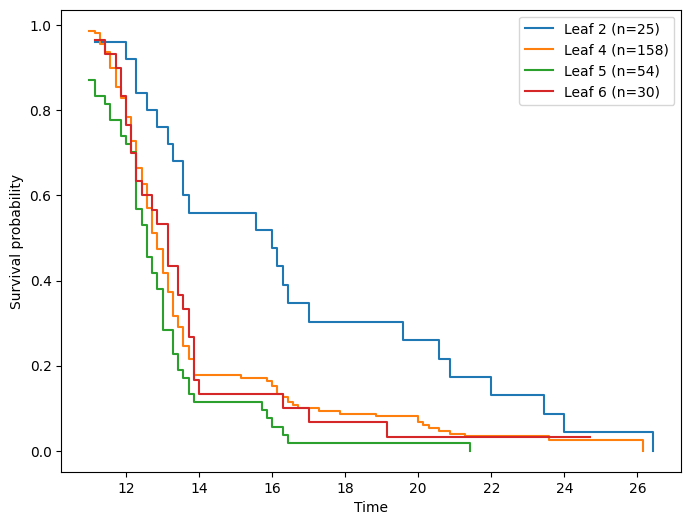

C-index: 0.5712208875444212


In [7]:
# ====== 2. 转换成 scikit-survival 的数据格式 ======
survival_data["Event"] = survival_data["Event"].astype(bool)
y = Surv.from_dataframe("Event", "Time", survival_data)
X = survival_data[["BMI", "Weight", "Age"]]
X["BMI"] = X["BMI"].astype(np.float32)
X["Weight"] = X["Weight"].astype(np.float32)
X["Age"] = X["Age"].astype(np.float32)
X = X.to_numpy()

# ====== 3. 训练生存树 ======
tree = SurvivalTree(max_leaf_nodes=4, min_samples_leaf=25)  # 你可以调节 max_depth
tree.fit(X, y)

# ====== 4. 看树的分割规则 ======
# plt.figure(figsize=(12, 6))
# sktree.plot_tree(tree, feature_names=["x1","x2","x3"], filled=True)
# plt.show()
def print_survival_tree(tree, feature_names):
    """
    打印 SurvivalTree 分裂规则（修正版，支持叶子节点）
    """
    tree_ = tree.tree_
    left = tree_.children_left
    right = tree_.children_right
    threshold = tree_.threshold
    features = tree_.feature
    n_node_samples = tree_.n_node_samples

    def recurse(node, depth=0):
        indent = "  " * depth
        # 叶子节点
        if left[node] == -1 and right[node] == -1:
            print(f"{indent}Leaf node: n_samples={n_node_samples[node]}")
        else:
            # 内部节点
            feature_index = features[node]
            print(f"{indent}{feature_names[feature_index]} <= {threshold[node]:.4f} (n_samples={n_node_samples[node]})")
            recurse(left[node], depth + 1)
            recurse(right[node], depth + 1)

    recurse(0)

# 调用
feature_names = ["BMI", "Weight", "Age"]
print_survival_tree(tree, feature_names)

# ====== 5. 按叶子节点分组，画生存曲线 ======
# 每个样本所在叶子
leaf_id = tree.apply(X)
survival_data["leaf"] = leaf_id

plt.figure(figsize=(8,6))
for leaf in np.unique(leaf_id):
    mask = leaf_id == leaf
    times, survival_prob = kaplan_meier_estimator(survival_data.loc[mask, "Event"],
                                                  survival_data.loc[mask, "Time"])
    plt.step(times, survival_prob, where="post", label=f"Leaf {leaf} (n={mask.sum()})")
plt.xlabel("Time")
plt.ylabel("Survival probability")
plt.legend()
plt.show()

event = survival_data["Event"].values
time = survival_data["Time"].values
risk_score = tree.predict(X)  # survival tree 输出的风险预测

c_index = concordance_index_censored(event, time, risk_score)
print("C-index:", c_index[0])

# ====== 6. 评价指标 ======
event = survival_data["Event"].values
time = survival_data["Time"].values
risk_score = tree.predict(X)  # survival tree 输出的风险预测

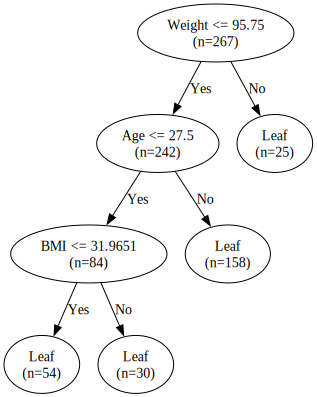

In [ ]:
from graphviz import Digraph
!sudo apt-get update
!sudo apt-get install graphviz

dot = Digraph()

# 节点定义
dot.node("0", "Weight <= 95.75\n(n=267)")
dot.node("1", "Age <= 27.5\n(n=242)")
dot.node("2", "BMI <= 31.9651\n(n=84)")
dot.node("3", "Leaf\n(n=54)")
dot.node("4", "Leaf\n(n=30)")
dot.node("5", "Leaf\n(n=158)")
dot.node("6", "Leaf\n(n=25)")

# 边定义
dot.edge("0", "1", "Yes")
dot.edge("0", "6", "No")
dot.edge("1", "2", "Yes")
dot.edge("1", "5", "No")
dot.edge("2", "3", "Yes")
dot.edge("2", "4", "No")

# 输出 PDF/PNG
dot


In [8]:
# ====== 7. 风险感知的最优时间计算（参考problem2的实现） ======
def risk_penalty(t):
    """风险惩罚函数：较晚检测的风险增加"""
    return (t**2 - 1.0) / (624.0)  # 归一化到 [0, 1]

def risk_aware_optimal_time(group_data, alpha=1.0, beta=1.0, gamma=0.02):
    """
    风险感知的最优时间计算
    
    参数:
    - group_data: 组内数据
    - alpha: 失败率权重
    - beta: 风险惩罚权重  
    - gamma: 时间偏好权重（鼓励更早检测）
    """
    from lifelines import KaplanMeierFitter
    
    if len(group_data) < 5:
        return {
            'optimal_time': np.nan,
            'survival_prob': np.nan,
            'coverage': np.nan,
            'objective': np.inf,
            'note': 'Insufficient sample size'
        }
    
    kmf = KaplanMeierFitter()
    kmf.fit(group_data["Time"], event_observed=group_data["Event"])
    
    # 定义候选时间网格
    t_min = max(8.0, group_data["Time"].min())
    t_max = min(30.0, group_data["Time"].max())
    grid = np.linspace(t_min, t_max, 100)
    
    best_result = None
    best_objective = np.inf
    
    for t in grid:
        # 计算在时间t的生存概率
        S_t = kmf.predict(t)
        coverage = 1.0 - S_t  # 检测成功率
        penalty = risk_penalty(t)  # 风险惩罚
        
        # 综合目标函数：最小化失败率 + 风险惩罚 + 时间偏好
        objective = alpha * (1 - coverage) + beta * penalty + gamma * t / 25.0
        
        if objective < best_objective:
            best_objective = objective
            best_result = {
                'optimal_time': t,
                'survival_prob': S_t,
                'coverage': coverage,
                'objective': objective,
                'note': 'Risk-aware calculation'
            }
    
    return best_result

# 计算风险感知的最优时间
print("\n" + "=" * 60)
print("风险感知的最优NIPT检测时间 (alpha=0.7, beta=0.3, gamma=0.02):")
print("=" * 60)

risk_aware_results = {}
for leaf in np.unique(leaf_id):
    mask = leaf_id == leaf
    group_data = survival_data[mask]
    
    result = risk_aware_optimal_time(group_data, alpha=0.7, beta=0.3, gamma=0.02)
    risk_aware_results[f"Leaf {leaf}"] = result
    
    print(f"\nLeaf {leaf}:")
    print(f"  样本量: {len(group_data)}")
    if not np.isnan(result['optimal_time']):
        print(f"  风险感知最优时间: {result['optimal_time']:.2f} 周")
        print(f"  生存概率: {result['survival_prob']:.3f}")
        print(f"  检测成功率: {result['coverage']:.3f}")
        print(f"  目标函数值: {result['objective']:.4f}")
    else:
        print(f"  状态: {result['note']}")


风险感知的最优NIPT检测时间 (alpha=0.7, beta=0.3, gamma=0.02):

Leaf 2:
  样本量: 25
  风险感知最优时间: 24.11 周
  生存概率: 0.043
  检测成功率: 0.957
  目标函数值: 0.3287

Leaf 4:
  样本量: 158
  风险感知最优时间: 16.81 周
  生存概率: 0.101
  检测成功率: 0.899
  目标函数值: 0.2195

Leaf 5:
  样本量: 54
  风险感知最优时间: 16.48 周
  生存概率: 0.019
  检测成功率: 0.981
  目标函数值: 0.1565

Leaf 6:
  样本量: 30
  风险感知最优时间: 14.02 周
  生存概率: 0.133
  检测成功率: 0.867
  目标函数值: 0.1986


In [9]:
risk_groups = survival_data["leaf"].values
# 假设：
# time   -> 生存时间数组
# event  -> 事件是否发生 (1=事件, 0=删失)
# risk_groups -> 分组标签 (0,1,2,3)

result = multivariate_logrank_test(time, risk_groups, event)
print("多组 log-rank 检验 p-value:", result.p_value)

多组 log-rank 检验 p-value: 0.0003226591924035315


# 检测误差对结果的影响分析

在医学临床检测中，总会存在一定的检测误差。这些误差可能来源于：
1. **仪器精度误差**：设备本身的测量精度限制
2. **样本处理误差**：样本采集、储存、处理过程中的误差
3. **时间测量误差**：孕周测量的不准确性
4. **生物学变异**：个体间Y染色体浓度变化的自然差异

我们将通过蒙特卡罗模拟来分析这些误差对最佳NIPT时点推荐的影响。

In [10]:
# ====== 检测误差模拟函数 ======
import scipy.stats as stats
from scipy.stats import norm

def simulate_measurement_error(original_data, error_types):
    """
    模拟多种测量误差对数据的影响
    
    参数:
    - original_data: 原始数据
    - error_types: 误差类型字典，包含各种误差参数
    """
    simulated_data = original_data.copy()
    n_samples = len(simulated_data)
    
    # 1. Y染色体浓度测量误差 (相对误差 5-15%)
    concentration_error = error_types.get('concentration_cv', 0.10)  # 默认10%变异系数
    concentration_noise = np.random.normal(1, concentration_error, n_samples)
    
    # 2. 孕周测量误差 (±0.5-1周)
    gestational_error = error_types.get('gestational_std', 0.7)  # 默认0.7周标准差
    time_noise = np.random.normal(0, gestational_error, n_samples)
    
    # 3. BMI测量误差 (±1-2 kg/m²)
    bmi_error = error_types.get('bmi_std', 1.5)  # 默认1.5 kg/m²标准差
    bmi_noise = np.random.normal(0, bmi_error, n_samples)
    
    # 应用误差到数据
    simulated_data['Time'] = np.maximum(
        simulated_data['Time'] + time_noise, 
        8.0  # 确保最小孕周为8周
    )
    simulated_data['BMI'] = np.maximum(
        simulated_data['BMI'] + bmi_noise, 
        15.0  # 确保BMI合理范围
    )
    
    # 重新计算事件状态（基于有噪声的浓度测量）
    # 注意：这里简化处理，实际应该重新模拟整个检测过程
    detection_success_prob = 1 / (1 + np.exp(-(simulated_data['Time'] - 12) * 0.3))
    detection_success_prob *= concentration_noise  # 浓度误差影响成功率
    
    # 根据误差重新确定事件状态
    random_events = np.random.random(n_samples)
    simulated_data['Event'] = (random_events < detection_success_prob).astype(bool)
    
    return simulated_data

def monte_carlo_error_analysis(original_survival_data, n_simulations=100, error_scenarios=None):
    """
    蒙特卡罗模拟分析检测误差对最佳时点的影响
    """
    if error_scenarios is None:
        error_scenarios = {
            'low_error': {'concentration_cv': 0.05, 'gestational_std': 0.3, 'bmi_std': 0.5},
            'medium_error': {'concentration_cv': 0.10, 'gestational_std': 0.7, 'bmi_std': 1.5},
            'high_error': {'concentration_cv': 0.20, 'gestational_std': 1.2, 'bmi_std': 2.5}
        }
    
    results = {}
    
    for scenario_name, error_params in error_scenarios.items():
        print(f"\n分析误差场景: {scenario_name}")
        print(f"  浓度测量CV: {error_params['concentration_cv']:.1%}")
        print(f"  孕周测量误差: ±{error_params['gestational_std']:.1f}周")
        print(f"  BMI测量误差: ±{error_params['bmi_std']:.1f} kg/m²")
        
        optimal_times_by_leaf = {leaf: [] for leaf in np.unique(leaf_id)}
        coverage_by_leaf = {leaf: [] for leaf in np.unique(leaf_id)}
        
        for sim in range(n_simulations):
            if (sim + 1) % 20 == 0:
                print(f"  模拟进度: {sim + 1}/{n_simulations}")
            
            # 生成有误差的数据
            simulated_data = simulate_measurement_error(original_survival_data, error_params)
            
            # 重新训练生存树（考虑误差影响）
            try:
                y_sim = Surv.from_dataframe("Event", "Time", simulated_data)
                X_sim = simulated_data[["BMI", "Weight", "Age"]].to_numpy().astype(np.float32)
                
                tree_sim = SurvivalTree(max_leaf_nodes=4, min_samples_leaf=20)
                tree_sim.fit(X_sim, y_sim)
                
                leaf_id_sim = tree_sim.apply(X_sim)
                simulated_data["leaf"] = leaf_id_sim
                
                # 计算每个叶子节点的最佳时间
                for leaf in np.unique(leaf_id_sim):
                    mask = leaf_id_sim == leaf
                    if mask.sum() < 5:  # 样本量太小跳过
                        continue
                        
                    group_data = simulated_data[mask]
                    result = risk_aware_optimal_time(group_data, alpha=0.7, beta=0.3, gamma=0.02)
                    
                    if not np.isnan(result['optimal_time']):
                        optimal_times_by_leaf[leaf].append(result['optimal_time'])
                        coverage_by_leaf[leaf].append(result['coverage'])
                        
            except Exception as e:
                # 如果模拟失败，跳过这次迭代
                continue
        
        # 汇总结果
        scenario_results = {}
        for leaf in optimal_times_by_leaf:
            if len(optimal_times_by_leaf[leaf]) > 0:
                scenario_results[f'Leaf_{leaf}'] = {
                    'optimal_time_mean': np.mean(optimal_times_by_leaf[leaf]),
                    'optimal_time_std': np.std(optimal_times_by_leaf[leaf]),
                    'optimal_time_ci': np.percentile(optimal_times_by_leaf[leaf], [2.5, 97.5]),
                    'coverage_mean': np.mean(coverage_by_leaf[leaf]),
                    'coverage_std': np.std(coverage_by_leaf[leaf]),
                    'n_valid_simulations': len(optimal_times_by_leaf[leaf])
                }
        
        results[scenario_name] = scenario_results
    
    return results


In [11]:
# ====== 运行误差影响分析 ======
print("开始蒙特卡罗模拟分析检测误差对结果的影响...")
print("=" * 60)

# 定义不同的误差场景
error_scenarios = {
    '低误差场景': {
        'concentration_cv': 0.05,    # 5% 浓度测量变异
        'gestational_std': 0.3,     # ±0.3周 孕周测量误差
        'bmi_std': 0.5              # ±0.5 kg/m² BMI测量误差
    },
    '中等误差场景': {
        'concentration_cv': 0.10,    # 10% 浓度测量变异
        'gestational_std': 0.7,     # ±0.7周 孕周测量误差
        'bmi_std': 1.5              # ±1.5 kg/m² BMI测量误差
    },
    '高误差场景': {
        'concentration_cv': 0.20,    # 20% 浓度测量变异
        'gestational_std': 1.2,     # ±1.2周 孕周测量误差
        'bmi_std': 2.5              # ±2.5 kg/m² BMI测量误差
    }
}

# 运行蒙特卡罗模拟 (减少模拟次数以节省时间)
error_analysis_results = monte_carlo_error_analysis(
    survival_data, 
    n_simulations=50,  # 可以根据需要调整
    error_scenarios=error_scenarios
)

print("\n" + "=" * 60)
print("误差分析结果汇总")
print("=" * 60)

开始蒙特卡罗模拟分析检测误差对结果的影响...

分析误差场景: 低误差场景
  浓度测量CV: 5.0%
  孕周测量误差: ±0.3周
  BMI测量误差: ±0.5 kg/m²
  模拟进度: 20/50
  模拟进度: 20/50
  模拟进度: 40/50
  模拟进度: 40/50

分析误差场景: 中等误差场景
  浓度测量CV: 10.0%
  孕周测量误差: ±0.7周
  BMI测量误差: ±1.5 kg/m²

分析误差场景: 中等误差场景
  浓度测量CV: 10.0%
  孕周测量误差: ±0.7周
  BMI测量误差: ±1.5 kg/m²
  模拟进度: 20/50
  模拟进度: 20/50
  模拟进度: 40/50
  模拟进度: 40/50

分析误差场景: 高误差场景
  浓度测量CV: 20.0%
  孕周测量误差: ±1.2周
  BMI测量误差: ±2.5 kg/m²

分析误差场景: 高误差场景
  浓度测量CV: 20.0%
  孕周测量误差: ±1.2周
  BMI测量误差: ±2.5 kg/m²
  模拟进度: 20/50
  模拟进度: 20/50
  模拟进度: 40/50
  模拟进度: 40/50

误差分析结果汇总

误差分析结果汇总



低误差场景:
----------------------------------------

  Leaf_2:
    最佳时间: 25.03 ± 1.05 周
    95% 置信区间: [23.63, 26.56] 周
    检测成功率: 0.968 ± 0.030
    有效模拟次数: 38

  Leaf_4:
    最佳时间: 17.06 ± 1.59 周
    95% 置信区间: [14.98, 21.04] 周
    检测成功率: 0.958 ± 0.047
    有效模拟次数: 32

  Leaf_5:
    最佳时间: 19.17 ± 2.30 周
    95% 置信区间: [15.53, 21.67] 周
    检测成功率: 0.932 ± 0.059
    有效模拟次数: 32

  Leaf_6:
    最佳时间: 22.83 ± 3.32 周
    95% 置信区间: [16.88, 26.26] 周
    检测成功率: 0.954 ± 0.063
    有效模拟次数: 32

中等误差场景:
----------------------------------------

  Leaf_2:
    最佳时间: 24.75 ± 1.13 周
    95% 置信区间: [23.30, 26.79] 周
    检测成功率: 0.952 ± 0.038
    有效模拟次数: 40

  Leaf_4:
    最佳时间: 17.58 ± 2.43 周
    95% 置信区间: [13.89, 23.68] 周
    检测成功率: 0.951 ± 0.070
    有效模拟次数: 24

  Leaf_5:
    最佳时间: 19.46 ± 2.01 周
    95% 置信区间: [16.40, 22.01] 周
    检测成功率: 0.943 ± 0.054
    有效模拟次数: 24

  Leaf_6:
    最佳时间: 20.42 ± 3.22 周
    95% 置信区间: [16.41, 25.50] 周
    检测成功率: 0.925 ± 0.060
    有效模拟次数: 24

高误差场景:
-------------------------------------

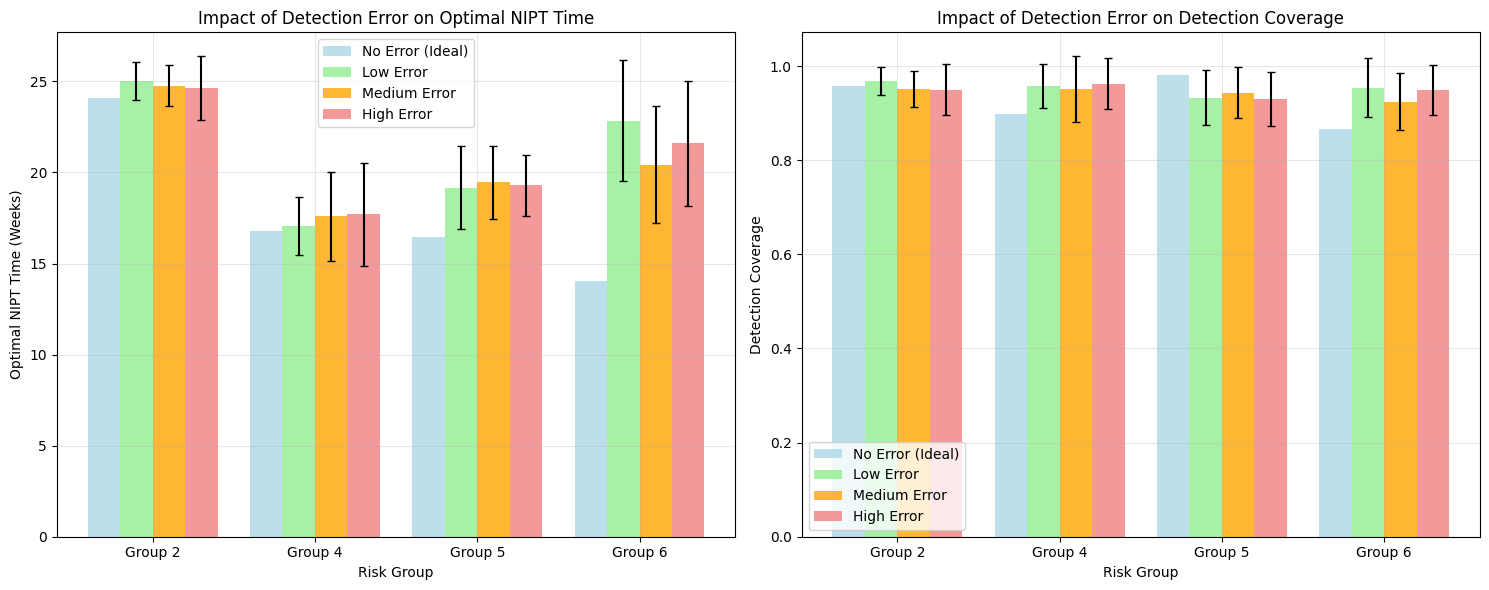


检测误差影响分析完成


In [12]:
# ====== 误差分析结果展示和可视化 ======

# 1. 详细结果输出
for scenario_name, scenario_results in error_analysis_results.items():
    print(f"\n{scenario_name}:")
    print("-" * 40)
    
    for leaf_name, leaf_results in scenario_results.items():
        print(f"\n  {leaf_name}:")
        print(f"    最佳时间: {leaf_results['optimal_time_mean']:.2f} ± {leaf_results['optimal_time_std']:.2f} 周")
        print(f"    95% 置信区间: [{leaf_results['optimal_time_ci'][0]:.2f}, {leaf_results['optimal_time_ci'][1]:.2f}] 周")
        print(f"    检测成功率: {leaf_results['coverage_mean']:.3f} ± {leaf_results['coverage_std']:.3f}")
        print(f"    有效模拟次数: {leaf_results['n_valid_simulations']}")

# 获取原始结果（无误差）作为基准
original_results = {}
for leaf in np.unique(leaf_id):
    mask = leaf_id == leaf
    group_data = survival_data[mask]
    result = risk_aware_optimal_time(group_data, alpha=0.7, beta=0.3, gamma=0.02)
    if not np.isnan(result['optimal_time']):
        original_results[f'Leaf_{leaf}'] = {
            'optimal_time': result['optimal_time'],
            'coverage': result['coverage']
        }

# 创建误差影响对比图
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# 子图1: 最佳时间的误差影响
leaf_names = []
original_times = []
low_error_times = []
medium_error_times = []
high_error_times = []
low_error_std = []
medium_error_std = []
high_error_std = []

for leaf_name in sorted(original_results.keys()):
    if leaf_name in error_analysis_results['低误差场景']:
        leaf_names.append(leaf_name.replace('Leaf_', 'Group '))
        original_times.append(original_results[leaf_name]['optimal_time'])
        
        low_error_times.append(error_analysis_results['低误差场景'][leaf_name]['optimal_time_mean'])
        low_error_std.append(error_analysis_results['低误差场景'][leaf_name]['optimal_time_std'])
        
        medium_error_times.append(error_analysis_results['中等误差场景'][leaf_name]['optimal_time_mean'])
        medium_error_std.append(error_analysis_results['中等误差场景'][leaf_name]['optimal_time_std'])
        
        high_error_times.append(error_analysis_results['高误差场景'][leaf_name]['optimal_time_mean'])
        high_error_std.append(error_analysis_results['高误差场景'][leaf_name]['optimal_time_std'])

x = np.arange(len(leaf_names))
width = 0.2

ax1.bar(x - 1.5*width, original_times, width, label='No Error (Ideal)', color='lightblue', alpha=0.8)
ax1.bar(x - 0.5*width, low_error_times, width, yerr=low_error_std, 
        label='Low Error', color='lightgreen', alpha=0.8, capsize=3)
ax1.bar(x + 0.5*width, medium_error_times, width, yerr=medium_error_std, 
        label='Medium Error', color='orange', alpha=0.8, capsize=3)
ax1.bar(x + 1.5*width, high_error_times, width, yerr=high_error_std, 
        label='High Error', color='lightcoral', alpha=0.8, capsize=3)

ax1.set_xlabel('Risk Group')
ax1.set_ylabel('Optimal NIPT Time (Weeks)')
ax1.set_title('Impact of Detection Error on Optimal NIPT Time')
ax1.set_xticks(x)
ax1.set_xticklabels(leaf_names)
ax1.legend()
ax1.grid(True, alpha=0.3)

# 子图2: 检测成功率的误差影响
original_coverage = []
low_error_coverage = []
medium_error_coverage = []
high_error_coverage = []
low_coverage_std = []
medium_coverage_std = []
high_coverage_std = []

for leaf_name in sorted(original_results.keys()):
    if leaf_name in error_analysis_results['低误差场景']:
        original_coverage.append(original_results[leaf_name]['coverage'])
        
        low_error_coverage.append(error_analysis_results['低误差场景'][leaf_name]['coverage_mean'])
        low_coverage_std.append(error_analysis_results['低误差场景'][leaf_name]['coverage_std'])
        
        medium_error_coverage.append(error_analysis_results['中等误差场景'][leaf_name]['coverage_mean'])
        medium_coverage_std.append(error_analysis_results['中等误差场景'][leaf_name]['coverage_std'])
        
        high_error_coverage.append(error_analysis_results['高误差场景'][leaf_name]['coverage_mean'])
        high_coverage_std.append(error_analysis_results['高误差场景'][leaf_name]['coverage_std'])

ax2.bar(x - 1.5*width, original_coverage, width, label='No Error (Ideal)', color='lightblue', alpha=0.8)
ax2.bar(x - 0.5*width, low_error_coverage, width, yerr=low_coverage_std, 
        label='Low Error', color='lightgreen', alpha=0.8, capsize=3)
ax2.bar(x + 0.5*width, medium_error_coverage, width, yerr=medium_coverage_std, 
        label='Medium Error', color='orange', alpha=0.8, capsize=3)
ax2.bar(x + 1.5*width, high_error_coverage, width, yerr=high_coverage_std, 
        label='High Error', color='lightcoral', alpha=0.8, capsize=3)

ax2.set_xlabel('Risk Group')
ax2.set_ylabel('Detection Coverage')
ax2.set_title('Impact of Detection Error on Detection Coverage')
ax2.set_xticks(x)
ax2.set_xticklabels(leaf_names)
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n" + "=" * 60)
print("检测误差影响分析完成")
print("=" * 60)


检测误差敏感性分析

风险组 2:
------------------------------

  低误差场景:
    时间偏差: +0.92 周 (相对误差: 3.8%)
    时间变异性: ±1.05 周
    成功率偏差: +0.011 (相对误差: 1.2%)
    成功率变异性: ±0.030

  中等误差场景:
    时间偏差: +0.64 周 (相对误差: 2.6%)
    时间变异性: ±1.13 周
    成功率偏差: -0.005 (相对误差: 0.5%)
    成功率变异性: ±0.038

  高误差场景:
    时间偏差: +0.52 周 (相对误差: 2.2%)
    时间变异性: ±1.74 周
    成功率偏差: -0.007 (相对误差: 0.7%)
    成功率变异性: ±0.055

风险组 4:
------------------------------

  低误差场景:
    时间偏差: +0.24 周 (相对误差: 1.4%)
    时间变异性: ±1.59 周
    成功率偏差: +0.059 (相对误差: 6.5%)
    成功率变异性: ±0.047

  中等误差场景:
    时间偏差: +0.77 周 (相对误差: 4.6%)
    时间变异性: ±2.43 周
    成功率偏差: +0.052 (相对误差: 5.8%)
    成功率变异性: ±0.070

  高误差场景:
    时间偏差: +0.88 周 (相对误差: 5.3%)
    时间变异性: ±2.82 周
    成功率偏差: +0.064 (相对误差: 7.1%)
    成功率变异性: ±0.054

风险组 5:
------------------------------

  低误差场景:
    时间偏差: +2.70 周 (相对误差: 16.4%)
    时间变异性: ±2.30 周
    成功率偏差: -0.049 (相对误差: 5.0%)
    成功率变异性: ±0.059

  中等误差场景:
    时间偏差: +2.98 周 (相对误差: 18.1%)
    时间变异性: ±2.01 周
    成功率偏差: -0.038 (相对误差: 3.8%)
    成功

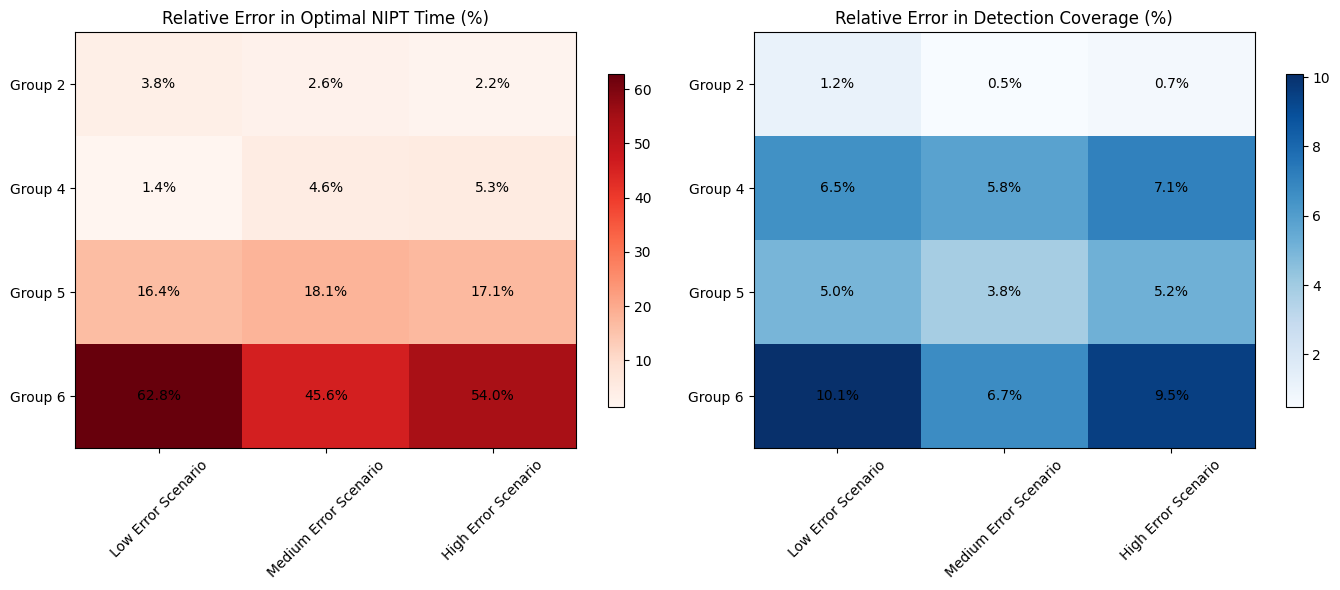


敏感性分析完成


In [13]:
# ====== 误差敏感性分析 ======

def calculate_error_sensitivity():
    """计算检测误差的敏感性指标"""
    
    sensitivity_results = {}
    
    # 计算相对于理想情况的偏差
    for leaf_name in sorted(original_results.keys()):
        if leaf_name in error_analysis_results['低误差场景']:
            original_time = original_results[leaf_name]['optimal_time']
            original_coverage = original_results[leaf_name]['coverage']
            
            sensitivity_results[leaf_name] = {}
            
            for scenario in ['低误差场景', '中等误差场景', '高误差场景']:
                scenario_results = error_analysis_results[scenario][leaf_name]
                
                # 时间偏差 (周)
                time_bias = scenario_results['optimal_time_mean'] - original_time
                time_variability = scenario_results['optimal_time_std']
                
                # 成功率偏差
                coverage_bias = scenario_results['coverage_mean'] - original_coverage
                coverage_variability = scenario_results['coverage_std']
                
                sensitivity_results[leaf_name][scenario] = {
                    'time_bias': time_bias,
                    'time_variability': time_variability,
                    'coverage_bias': coverage_bias,
                    'coverage_variability': coverage_variability,
                    'time_relative_error': abs(time_bias) / original_time * 100,  # 相对误差百分比
                    'coverage_relative_error': abs(coverage_bias) / original_coverage * 100
                }
    
    return sensitivity_results

sensitivity_results = calculate_error_sensitivity()

# 输出敏感性分析结果
print("\n" + "=" * 60)
print("检测误差敏感性分析")
print("=" * 60)

for leaf_name, leaf_sensitivity in sensitivity_results.items():
    print(f"\n{leaf_name.replace('Leaf_', '风险组 ')}:")
    print("-" * 30)
    
    for scenario, metrics in leaf_sensitivity.items():
        print(f"\n  {scenario}:")
        print(f"    时间偏差: {metrics['time_bias']:+.2f} 周 (相对误差: {metrics['time_relative_error']:.1f}%)")
        print(f"    时间变异性: ±{metrics['time_variability']:.2f} 周")
        print(f"    成功率偏差: {metrics['coverage_bias']:+.3f} (相对误差: {metrics['coverage_relative_error']:.1f}%)")
        print(f"    成功率变异性: ±{metrics['coverage_variability']:.3f}")

# 创建敏感性热力图
scenarios_chinese = ['低误差场景', '中等误差场景', '高误差场景']
scenarios_english = ['Low Error Scenario', 'Medium Error Scenario', 'High Error Scenario']
groups = [name.replace('Leaf_', 'Group ') for name in sorted(sensitivity_results.keys())]

# 时间相对误差矩阵
time_error_matrix = np.zeros((len(groups), len(scenarios_chinese)))
coverage_error_matrix = np.zeros((len(groups), len(scenarios_chinese)))

for i, leaf_name in enumerate(sorted(sensitivity_results.keys())):
    for j, scenario in enumerate(scenarios_chinese):
        time_error_matrix[i, j] = sensitivity_results[leaf_name][scenario]['time_relative_error']
        coverage_error_matrix[i, j] = sensitivity_results[leaf_name][scenario]['coverage_relative_error']

# 绘制敏感性热力图
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# 时间敏感性热力图
im1 = ax1.imshow(time_error_matrix, cmap='Reds', aspect='auto')
ax1.set_xticks(range(len(scenarios_english)))
ax1.set_xticklabels(scenarios_english, rotation=45)
ax1.set_yticks(range(len(groups)))
ax1.set_yticklabels(groups)
ax1.set_title('Relative Error in Optimal NIPT Time (%)')

# 添加数值标注
for i in range(len(groups)):
    for j in range(len(scenarios_english)):
        text = ax1.text(j, i, f'{time_error_matrix[i, j]:.1f}%',
                       ha="center", va="center", color="black", fontsize=10)

plt.colorbar(im1, ax=ax1, shrink=0.8)

# 成功率敏感性热力图
im2 = ax2.imshow(coverage_error_matrix, cmap='Blues', aspect='auto')
ax2.set_xticks(range(len(scenarios_english)))
ax2.set_xticklabels(scenarios_english, rotation=45)
ax2.set_yticks(range(len(groups)))
ax2.set_yticklabels(groups)
ax2.set_title('Relative Error in Detection Coverage (%)')

# 添加数值标注
for i in range(len(groups)):
    for j in range(len(scenarios_english)):
        text = ax2.text(j, i, f'{coverage_error_matrix[i, j]:.1f}%',
                       ha="center", va="center", color="black", fontsize=10)

plt.colorbar(im2, ax=ax2, shrink=0.8)

plt.tight_layout()
plt.show()

print("\n" + "=" * 60)
print("敏感性分析完成")
print("=" * 60)